___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# GANs - Generative Adverserial Networks

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from tensorflow.keras.datasets import mnist

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

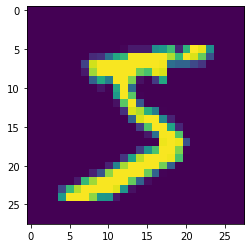

In [19]:
plt.imshow(X_train[0])

In [20]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Reshape and Rescale Images for DCGAN

Generator will use tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.

In [21]:
X_train = X_train/255

In [22]:
#since we are using tanh activation function which ranges from -1 to 1, we scale and reshape images so that values range 
#from -1 to 1
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [23]:
X_train.min()

-1.0

In [24]:
X_train.max()

1.0

## Filtering out the Data for Faster Training on Smaller Dataset

In [28]:
only_zeros = X_train[y_train==0]

In [29]:
only_zeros.shape

(5923, 28, 28, 1)

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [32]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))


In [35]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [40]:
GAN = Sequential([generator, discriminator])

In [41]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [42]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [43]:
GAN.layers

In [44]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [45]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [46]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

### Setting up Training Batches

In [47]:
import tensorflow as tf

In [48]:
batch_size = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. 

In [49]:
# my_data = X_train
my_data = only_zeros

In [50]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [51]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [52]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [53]:
epochs = 20

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

## Training Loop

In [54]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

In [31]:
# Most likely your generator will only learn to create one type of noisey zero
# Regardless of what noise is passed in.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

In [55]:
noise = tf.random.normal(shape=[10, codings_size])

In [56]:
noise.shape

TensorShape([10, 100])

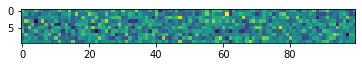

In [57]:
plt.imshow(noise)

In [58]:
images = generator(noise)

In [61]:
single_image = images[1]

In [37]:
# single_image.numpy().reshape(28,28)

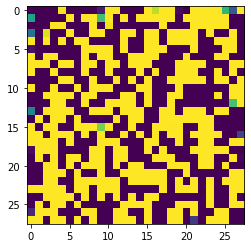

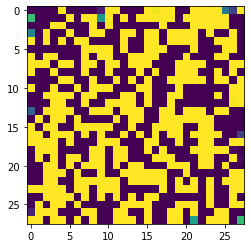

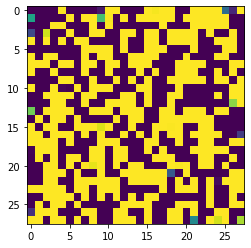

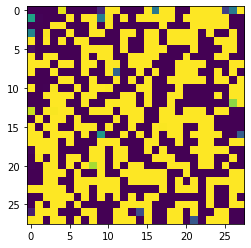

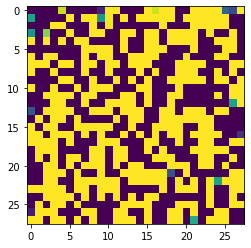

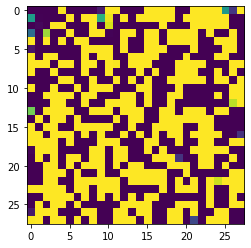

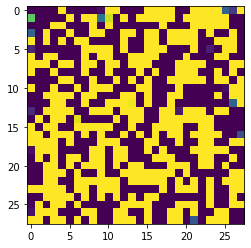

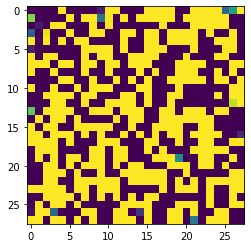

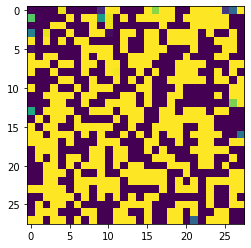

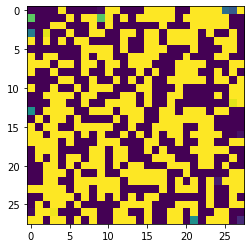

In [62]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()

**Review our conclusion video to learn about what is state-of-the-art in this field! We need very powerful GPUs to achieve realistic results!**